Using L = 669234 and U = 703552 and k = 3
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-21
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i5-12500H, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 486 rows, 432 columns and 1941 nonzeros
Model fingerprint: 0xafa9f6d9
Variable types: 156 continuous, 276 integer (276 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve time: 0.01s
Presolved: 486 rows, 432 columns, 1950 nonzeros
Variable types: 156 continuous, 276 integer (276 binary)

Root relaxation: objective 0.000000e+00, 166 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    B

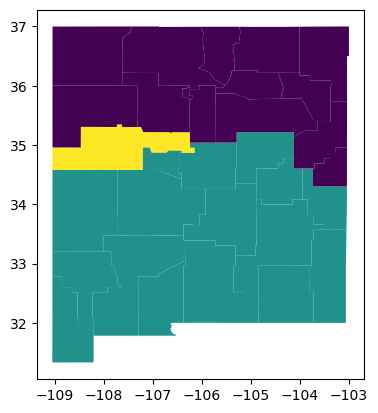

In [1]:
import json
from networkx.readwrite import json_graph
import networkx as nx
import gurobipy as gp
from gurobipy import GRB
import math
import os
import geopandas as gpd
import fiona

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data)

# Read New Mexico county graph from the json file "COUNTY_35.json"
filepath_json = 'districting--data'
filename_json = 'COUNTY_35.json'
G = read_graph_from_json(os.path.join(filepath_json, filename_json))

# Impose a 5% population deviation (+/- 0.5%)
deviation = 0.05

k = 3  # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1 - deviation / 2) * total_population / k)
U = math.floor((1 + deviation / 2) * total_population / k)
print("Using L =", L, "and U =", U, "and k =", k)

# create model
m = gp.Model()

# set variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY)
y = m.addVars(G.edges, vtype=GRB.BINARY)

# objective is to minimize cut edges
m.setObjective(gp.quicksum(y[u, v] for u, v in G.edges), GRB.MINIMIZE)

# add constraint: each county i is assigned to one district
m.addConstrs(gp.quicksum(x[i, j] for j in range(k)) == 1 for i in G.nodes)

# add constraint: each district has population at least L and at most U
m.addConstrs(gp.quicksum(G.nodes[i]['TOTPOP'] * x[i, j] for i in G.nodes) >= L for j in range(k))
m.addConstrs(gp.quicksum(G.nodes[i]['TOTPOP'] * x[i, j] for i in G.nodes) <= U for j in range(k))

# add constraint: edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs(x[i, v] - x[j, v] <= y[i, j] for i, j in G.edges for v in range(k))

m.update()

# Add contiguity constraints and re-solve the model.
# Using the contiguity constraints of Hojny et al. (MPC, 2021)
DG = nx.DiGraph(G)
f = m.addVars(DG.edges, vtype=GRB.CONTINUOUS)
M = G.number_of_nodes() - k + 1

r = m.addVars(G.nodes, k, vtype=GRB.BINARY)
m.addConstrs(gp.quicksum(r[i, j] for i in DG.nodes) == 1 for j in range(k))
m.addConstrs(r[i, j] <= x[i, j] for i in DG.nodes for j in range(k))
m.addConstrs(gp.quicksum(f[u, v] - f[v, u] for u in DG.neighbors(v)) >= 1 - M * gp.quicksum(r[v, j] for j in range(k)) for v in G.nodes)
m.addConstrs(f[i, j] + f[j, i] <= M * (1 - y[i, j]) for (i, j) in G.edges)

m.update()

# solve IP model
m.optimize()
print("The number of cut edges is", m.objval)

# retrieve the districts and their populations
districts = [[i for i in G.nodes if x[i, j].x > 0.5] for j in range(k)]
district_counties = [[G.nodes[i]["NAME10"] for i in districts[j]] for j in range(k)]
district_populations = [sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k)]

# print district info
for j in range(k):
    print("District", j, "has population", district_populations[j], "and contains counties", district_counties[j])

# Draw it on a map
try:
    # Specify the file path for shapefile
    directory_path_shp = 'districting--data'
    filename_shp = 'NM_counties (1).shp'
    full_path_shp = os.path.join(directory_path_shp, filename_shp)

    # Read geopandas dataframe from file
    df = gpd.read_file(full_path_shp)

    # Assign each county to a district
    assignment = [-1 for u in G.nodes]

    # for each district j
    for j in range(k):
        # for each node i in this district
        for i in districts[j]:
            # determine its GEOID
            geoID = G.nodes[i]["GEOID10"]
            # Need to find this GEOID in the dataframe
            for u in G.nodes:
                if geoID == df['GEOID10'][u]:  # Found it
                    assignment[u] = j  # Node u from the dataframe should be assigned to district j

    # Add the assignments to a column of the dataframe and map it
    df['assignment'] = assignment
    my_fig = df.plot(column='assignment').get_figure()

except fiona.errors.CPLE_OpenFailedError as e:
    print(f"Error opening shapefile: {e}")
except Exception as e:
    print(f"Other error: {e}")
